# Model selection using transfer learning feature extraction

This is the part 1 of three-part series:
1. `Model selection`
2. `Fine-tuning`
3. `Evaluation`

This notebook is the demonstration of choosing best model for covid-19 [dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database). The original dataset has more than two classes, however this notebook is only the modified version of the original dataset and that is the binary-class classification.

All pre-trained models are imported from the [Tensorflow Hub](https://www.tensorflow.org/hub) repository, **specifically** for *Image classification* and *Image feature vector* from [tfhub.dev](https://tfhub.dev/).

The four models are:
* [Resnet50_V2](https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5)
* [InceptionV3](https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5)
* [MobilenetV3](https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5)
* [Inception_resnetV2](https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5)



## First experiment: 50% training data

This experiment is the 40-20% split from initial 80-20% data (might sound confusing, hang on for later).

The first experiment has the following data size:
* Total images - 8,285 (2,170 covid/6,115 normal)
  * Traning images - 5,522 (1,446 covid/4,076 normal)
  * Test images - 2,763 (724 covid/2,039 normal)

Before moving on we need to import dependencies.

In [ ]:
import os
import random
import zipfile
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# TensorFlow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Connect with drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # Install Weights & Biases if not installed
# !pip install wandb

In [ ]:
# Import W&B
import wandb
from wandb.keras import WandbCallback

### Loading the data

**Note:** Make sure the directory path(s) are correct.

In [ ]:
# Unzip 50% data file from google drive (uncomment the cell & set the right path if using colab)
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/covid_ready_dataset/covid_radiography_50_percent.zip")
zip_ref.extractall()
zip_ref.close()

### Inspect the data

This file structure is formatted to typical format for working with images.

More specifically:
* `train` directory contains all of the images in the training dataset with subdirectories each named after a certain class (`covid` & `normal`) containing images of that class.
* `test` directory with the same structure as the `train` directory.

```
Example for file structure

covid_normal <- top level folder
└───train <- training images
│   └───covid
│   │   │   covid-1.jpg
│   │   │   covid-2.jpg
│   │   │   ...      
│   └───normal
│       │   normal-1.jpg
│       │   normal-2.jpg
│       │   ...
│   
└───test <- testing images
│   └───covid
│   │   │   covid-50.jpg
│   │   │   covid-51.jpg
│   │   │   ...      
│   └───normal
│       │   normal-50.jpg
│       │   normal-51.jpg
│       │   ...    
```

We can now inspect each of the available directories.

In [ ]:
# How many images in each folder
# Walk through 50 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("/content/covid_radiography_50_percent"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 2 directories and 0 images in '/content/covid_radiography_50_percent'.
there are 2 directories and 0 images in '/content/covid_radiography_50_percent/test'.
there are 0 directories and 2039 images in '/content/covid_radiography_50_percent/test/normal'.
there are 0 directories and 724 images in '/content/covid_radiography_50_percent/test/covid'.
there are 2 directories and 0 images in '/content/covid_radiography_50_percent/train'.
there are 0 directories and 4076 images in '/content/covid_radiography_50_percent/train/normal'.
there are 0 directories and 1446 images in '/content/covid_radiography_50_percent/train/covid'.


In [ ]:
# Get the class names
data_dir = pathlib.Path('/content/covid_radiography_50_percent/train')
class_names = np.array([item.name for item in data_dir.glob('*')])
print(class_names)

['normal' 'covid']


Visualize an image for better understanding of our data.

In [ ]:
# Create function to view a random image
def view_random_image(target_dir, target_class):
  # setup target directory
  target_folder = target_dir + "/" +target_class
  print(target_folder)

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')
  
  print(f'Image shape: {img.shape}')  # show the shape of the image

  return img

/content/covid_radiography_50_percent/train/covid
Image shape: (299, 299)


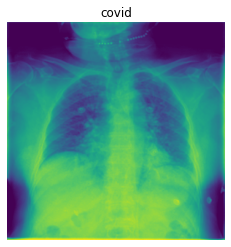

In [ ]:
# View a random image from training dataset
img = view_random_image(target_dir='/content/covid_radiography_50_percent/train',
                        target_class='covid')

In [ ]:
# view the img (it is a 2D array)
img

array([[0.18431373, 0.1254902 , 0.09411765, ..., 0.10588235, 0.11764706,
        0.14117648],
       [0.11372549, 0.05882353, 0.02745098, ..., 0.03529412, 0.04705882,
        0.07058824],
       [0.09019608, 0.04705882, 0.01960784, ..., 0.01176471, 0.02745098,
        0.04705882],
       ...,
       [0.58431375, 0.52156866, 0.5137255 , ..., 0.1882353 , 0.2627451 ,
        0.42745098],
       [0.7764706 , 0.7647059 , 0.76862746, ..., 0.43529412, 0.5058824 ,
        0.59607846],
       [0.83137256, 0.8509804 , 0.85490197, ..., 0.7372549 , 0.7411765 ,
        0.7019608 ]], dtype=float32)

In [ ]:
# View rescaled img values
img/255.

array([[7.2279893e-04, 4.9211847e-04, 3.6908881e-04, ..., 4.1522493e-04,
        4.6136102e-04, 5.5363326e-04],
       [4.4598232e-04, 2.3068051e-04, 1.0765091e-04, ..., 1.3840832e-04,
        1.8454441e-04, 2.7681663e-04],
       [3.5371011e-04, 1.8454441e-04, 7.6893506e-05, ..., 4.6136101e-05,
        1.0765091e-04, 1.8454441e-04],
       ...,
       [2.2914265e-03, 2.0453674e-03, 2.0146100e-03, ..., 7.3817762e-04,
        1.0303730e-03, 1.6762784e-03],
       [3.0449827e-03, 2.9988466e-03, 3.0142253e-03, ..., 1.7070358e-03,
        1.9838526e-03, 2.3375626e-03],
       [3.2602844e-03, 3.3371781e-03, 3.3525568e-03, ..., 2.8911957e-03,
        2.9065744e-03, 2.7527874e-03]], dtype=float32)

Notice the image is grayscale `(Height, Width)` but the pre-trained models are trained on rgb images `(Hight, Width, Channels)`. The models won't accept grayscale images so we have to deal with this issue. A workaround is by duplicating color channel of grayscale image 3 times when loading it to *flow_from_directory* and that is what the parameter `color_mode` is doing under the hood when we set it to `rgb` instead of `grayscale`.

Another thing to consider that none of the pre-trained models has pre-built rescaling function, so we ensure that images are rescaled.

### Creating data loaders

Now we have the data, let's use the [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class along with the `flow_from_directory` method to load in images.

In [ ]:
# Set image size
IMG_SIZE = (224, 224)

# Set up directory paths
train_dir = '/content/covid_radiography_50_percent/train'
test_dir = '/content/covid_radiography_50_percent/test'

# Preprocess data and rescale images
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Import data from directories and turn it into batches (default batch is 32)
train_data_50_percent = train_datagen.flow_from_directory(train_dir,
                                                         target_size=IMG_SIZE,  # covert images to 224 x 224
                                                         class_mode='binary',
                                                         color_mode='rgb',  # covert grayscale to rgb
                                                         seed=42)

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SIZE,
                                             class_mode='binary',
                                             color_mode='rgb',  # covert grayscale to rgb
                                             seed=42)

Found 5522 images belonging to 2 classes.
Found 2763 images belonging to 2 classes.


Loading in the data we see there are 5522 images in the training dataset belonging to 2 classes (1,446 covid/4,076 normal) and 2763 images in the test set 2,763 (724 covid/2,039 normal).

### Creating models using TensorFlow Hub

TensorFlow Hub offers many state of the art models to use from the shelf, leveraging the benefits of transfer learning and after going to some research papers about model experimentation on Covid-19 images (CXR) I decide to use following models for our experiments.

One important point to notice that we choose feature vector models so we can apply feature extraction transfer learning.

Let's get the feature vector URLs of models we are going to use.


In [ ]:
# MobileNetV3 feature vector
mobilenet_url = 'https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5'

# ResNet50 V2 feature vector
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

# InceptionV3 feature vector
inception_url = 'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5'

# Inception_ResnetV2
inception_resnet_url = 'https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5'

Since we're going to be comparing four models, we create a function `create_model()`. This function will take a model's TensorFlow Hub URL, instatiate a Keras Sequential model with the appropriate number of output layers and return the model.

In [ ]:
# Model definition
def create_model(model_url):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.

  Returns:
    An compiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with 1 output.
  """
  # Download the pretrained model and save it as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,  # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMG_SIZE+(3,))  # since the shape now has been duplicated by 3x
  
  # Create model
  model = tf.keras.Sequential([
        feature_extractor_layer,  # use the feature extraction layer as the base
        layers.Dense(1, activation='sigmoid', name='output_layer')  # create customize output layer
  ])

  return model

Now we've got a function for creating a model. It is time to compile and fit the model.

Before that we'll set our callbacks function first.

### Setting up callbacks

Before we build a model, we want to create a Keras [Callbacks](https://keras.io/api/callbacks/) to track our models building experiments.

Experiment tracking with [Weights & Biases](https://wandb.ai/site) - log the performance of multiple models and then view and compare these models in a visual way on [WandB Dashboard](https://wandb.ai/site/dashboard) (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on our data.

We first initialize our wandb run `.init`, there we need to set our hyperparameters. They're passed in as a dictionary via the `config` argument, and then become available as the `config` attribute of `wandb`.

**Note:** We will need to`pip install wandb` if it is not already installed.

In [ ]:
# Initialize wandb with our project name
run = wandb.init(project='MobileNetV3 vs. ResNetV2 vs. InceptionV3 vs. Inception_ResNetV2',
                 config={  # include hyperparameters and metadata
                     "learning_rate": 0.001,  # Adam default learning rate
                     "epochs": 5,
                     "batch_size": 32,  # default batch size
                     "loss_function": "binary_crossentropy",
                     "architecture": "MobileNetV3",
                     "dataset": "Covid-19 CXR 50 Percent Data"
                 })
config = wandb.config  # We'll use this to configure our experiment

# Initialize mobilenet model
tf.keras.backend.clear_session()
mobilenet_model = create_model(mobilenet_url)
mobilenet_model.summary()

# Compile the model
# Notice that we use config, so our metadata matches what gets executed
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
mobilenet_model.compile(optimizer, config.loss_function, metrics=['accuracy'])

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1024)              1529968   
_________________________________________________________________
output_layer (Dense)         (None, 1)                 1025      
Total params: 1,530,993
Trainable params: 1,025
Non-trainable params: 1,529,968
_________________________________________________________________


#### MobileNetV3 (50% data)

In [ ]:
# Fit the model
mobilenet_history = mobilenet_model.fit(train_data_50_percent,
                                        epochs=config.epochs,  # use config we created earlier
                                        batch_size=config.batch_size,  # same here
                                        steps_per_epoch=len(train_data_50_percent),
                                        validation_data=test_data,
                                        # go through less of the validation data so epochs are faster
                                        validation_steps=int(0.15*len(test_data)),
                                        # notice WandCallback is used as a regular callback and again we use config to set hyperparameters
                                        callbacks=[WandbCallback()])

Epoch 1/5
173/173 [==============================] - 54s 120ms/step - loss: 0.3455 - accuracy: 0.8629 - val_loss: 0.2594 - val_accuracy: 0.9062
Epoch 2/5
173/173 [==============================] - 20s 116ms/step - loss: 0.2340 - accuracy: 0.9171 - val_loss: 0.2058 - val_accuracy: 0.9375
Epoch 3/5
173/173 [==============================] - 20s 115ms/step - loss: 0.1956 - accuracy: 0.9305 - val_loss: 0.1831 - val_accuracy: 0.9399
Epoch 4/5
173/173 [==============================] - 20s 116ms/step - loss: 0.1742 - accuracy: 0.9388 - val_loss: 0.1522 - val_accuracy: 0.9423
Epoch 5/5
173/173 [==============================] - 20s 115ms/step - loss: 0.1599 - accuracy: 0.9440 - val_loss: 0.1430 - val_accuracy: 0.9663


It seems that after only 5 epochs, MobileNetV3 feature extraction model is able to achieve ~95% accuracy.

Let's check the loss curves. We create a function to plot model loss curves which will be helpful for use again for all other models as well.

In [ ]:
# plot the loss curves
def plot_loss_curves(history):
  """
  Args:
    history: Takes model saved history logs
  Returns:
    Separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('epochs')
  plt.legend();

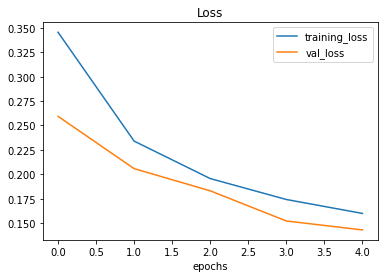

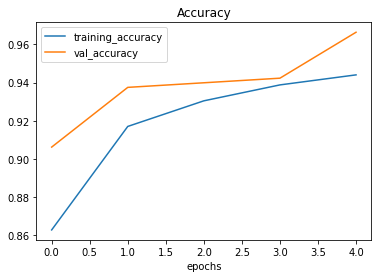

In [ ]:
plot_loss_curves(mobilenet_history)

The loss is still going down and accuracy to going up, which is a good sign that the model could improve if we would have left the training for longer.

Let's evaluate the model on whole test set. We also want to indicate that our run is completed using `run.finish()`.

In [ ]:
# Evaluate mobilenet on whole test set
mobilenet_loss, mobilenet_acc = mobilenet_model.evaluate(test_data)

# Experiment completed
run.finish()

87/87 [==============================] - 10s 112ms/step - loss: 0.1662 - accuracy: 0.9443


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▄▂▂▁
val_accuracy,▁▅▅▅█
val_loss,█▅▃▂▁
accuracy,0.94404
best_epoch,4
best_val_loss,0.14304
epoch,4
loss,0.15993
val_accuracy,0.96635


#### ResNet50V2 (50% data)

We will reinitialize the callback for new experiment and recompile the model.

In [ ]:
# Initialize wandb
run = wandb.init(project='MobileNetV3 vs. ResNetV2 vs. InceptionV3 vs. Inception_ResNetV2',
                 config={
                     "learning_rate": 0.001,
                     "epochs": 5,
                     "batch_size": 32,
                     "loss_function": "binary_crossentropy",
                     "architecture": "ResNetV2",
                     "dataset": "Covid-19 CXR 50 Percent Data"
                 })

# Configure
config = wandb.config

# Initialize resnet model
tf.keras.backend.clear_session()
resnet_model = create_model(resnet_url)
resnet_model.summary()

# Compile the model
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
resnet_model.compile(optimizer, config.loss_function, metrics=['accuracy'])

wandb: Currently logged in as: awon08 (use `wandb login --relogin` to force relogin)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Fit the model
resnet_history = resnet_model.fit(train_data_50_percent,
                                  epochs=config.epochs,
                                  batch_size=config.batch_size,
                                  steps_per_epoch=len(train_data_50_percent),
                                  validation_data=test_data,
                                  validation_steps=int(0.15*len(test_data)),
                                  callbacks=[WandbCallback()])

Epoch 1/5
173/173 [==============================] - 42s 211ms/step - loss: 0.3580 - accuracy: 0.8482 - val_loss: 0.2853 - val_accuracy: 0.8894
Epoch 2/5
173/173 [==============================] - 35s 204ms/step - loss: 0.2409 - accuracy: 0.9082 - val_loss: 0.2448 - val_accuracy: 0.8942
Epoch 3/5
173/173 [==============================] - 35s 203ms/step - loss: 0.2028 - accuracy: 0.9239 - val_loss: 0.2095 - val_accuracy: 0.9111
Epoch 4/5
173/173 [==============================] - 35s 202ms/step - loss: 0.1845 - accuracy: 0.9334 - val_loss: 0.1949 - val_accuracy: 0.9255
Epoch 5/5
173/173 [==============================] - 35s 203ms/step - loss: 0.1644 - accuracy: 0.9437 - val_loss: 0.1732 - val_accuracy: 0.9399


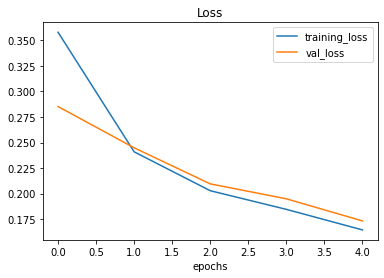

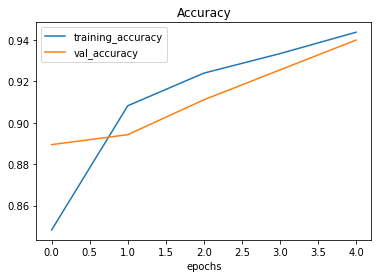

In [ ]:
# Plot loss curves of resnet model
plot_loss_curves(resnet_history)

In [ ]:
# Evaluate resnet on whole test data
resnet_loss, resnet_acc = resnet_model.evaluate(test_data)

run.finish()

87/87 [==============================] - 17s 197ms/step - loss: 0.1793 - accuracy: 0.9265


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
loss,█▄▂▂▁
val_accuracy,▁▂▄▆█
val_loss,█▅▃▂▁
accuracy,0.94368
best_epoch,4
best_val_loss,0.17319
epoch,4
loss,0.16439
val_accuracy,0.9399


#### InceptionV3 (50% data)

In [ ]:
# Initialize wandb
run = wandb.init(project='MobileNetV3 vs. ResNetV2 vs. InceptionV3 vs. Inception_ResNetV2',
                 config={
                     "learning_rate": 0.001,
                     "epochs": 5,
                     "batch_size": 32,
                     "loss_function": "binary_crossentropy",
                     "architecture": "InceptionV3",
                     "dataset": "Covid-19 CXR 50 Percent Data"
                 })

# Configure
config = wandb.config

# Initialize inception model
tf.keras.backend.clear_session()
inception_model = create_model(inception_url)
inception_model.summary()

# Compile the model
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
inception_model.compile(optimizer, config.loss_function, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              21802784  
_________________________________________________________________
output_layer (Dense)         (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
# Fit the model
inception_history = inception_model.fit(train_data_50_percent,
                                        epochs=config.epochs,
                                        batch_size=config.batch_size,
                                        steps_per_epoch=len(train_data_50_percent),
                                        validation_data=test_data,
                                        validation_steps=int(0.15*len(test_data)),
                                        callbacks=[WandbCallback()])

Epoch 1/5
173/173 [==============================] - 41s 190ms/step - loss: 0.3825 - accuracy: 0.8359 - val_loss: 0.2909 - val_accuracy: 0.8870
Epoch 2/5
173/173 [==============================] - 31s 178ms/step - loss: 0.3013 - accuracy: 0.8749 - val_loss: 0.3017 - val_accuracy: 0.8798
Epoch 3/5
173/173 [==============================] - 31s 176ms/step - loss: 0.2697 - accuracy: 0.8928 - val_loss: 0.2657 - val_accuracy: 0.8966
Epoch 4/5
173/173 [==============================] - 30s 176ms/step - loss: 0.2525 - accuracy: 0.8970 - val_loss: 0.2579 - val_accuracy: 0.8822
Epoch 5/5
173/173 [==============================] - 30s 176ms/step - loss: 0.2388 - accuracy: 0.9073 - val_loss: 0.1992 - val_accuracy: 0.9303


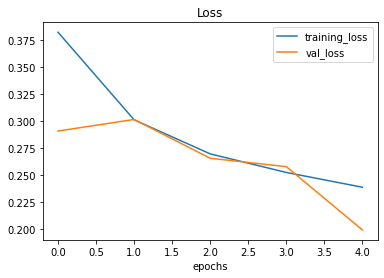

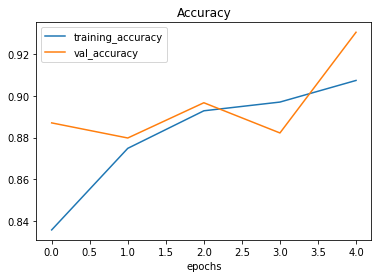

In [ ]:
# Plot loss curves
plot_loss_curves(inception_history)

In [ ]:
# Evaluate inception on whole test data
inception_loss, inception_acc = inception_model.evaluate(test_data)

run.finish()

87/87 [==============================] - 15s 175ms/step - loss: 0.2487 - accuracy: 0.9026


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
loss,█▄▃▂▁
val_accuracy,▂▁▃▁█
val_loss,▇█▆▅▁
accuracy,0.90728
best_epoch,4
best_val_loss,0.19922
epoch,4
loss,0.23881
val_accuracy,0.93029


#### Inception_ResnetV2 (50% data)

In [ ]:
# Initialize wandb with our project name
run = wandb.init(project='MobileNetV3 vs. ResNetV2 vs. InceptionV3 vs. Inception_ResNetV2',
                 config={
                     "learning_rate": 0.001,
                     "epochs": 5,
                     "batch_size": 32,
                     "loss_function": "binary_crossentropy",
                     "architecture": "Inception_ResNetV2",
                     "dataset": "Covid-19 CXR 50 Percent Data"
                 })

# Configure
config = wandb.config

# Initialize inception_resnet model
tf.keras.backend.clear_session()
inception_resnet_model = create_model(inception_resnet_url)
inception_resnet_model.summary()

# Compile the model
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
inception_resnet_model.compile(optimizer, config.loss_function, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1536)              54336736  
_________________________________________________________________
output_layer (Dense)         (None, 1)                 1537      
Total params: 54,338,273
Trainable params: 1,537
Non-trainable params: 54,336,736
_________________________________________________________________


In [ ]:
# Fit the model
inception_resnet_history = inception_resnet_model.fit(train_data_50_percent,
                                                      epochs=config.epochs,
                                                      batch_size=config.batch_size,
                                                      steps_per_epoch=len(train_data_50_percent),
                                                      validation_data=test_data,
                                                      validation_steps=int(0.15*len(test_data)),
                                                      callbacks=[WandbCallback()])

Epoch 1/5
173/173 [==============================] - 93s 442ms/step - loss: 0.4004 - accuracy: 0.8303 - val_loss: 0.3013 - val_accuracy: 0.8822
Epoch 2/5
173/173 [==============================] - 74s 425ms/step - loss: 0.3200 - accuracy: 0.8676 - val_loss: 0.2983 - val_accuracy: 0.8822
Epoch 3/5
173/173 [==============================] - 73s 424ms/step - loss: 0.2878 - accuracy: 0.8845 - val_loss: 0.2608 - val_accuracy: 0.8846
Epoch 4/5
173/173 [==============================] - 73s 424ms/step - loss: 0.2665 - accuracy: 0.8953 - val_loss: 0.2651 - val_accuracy: 0.9038
Epoch 5/5
173/173 [==============================] - 73s 424ms/step - loss: 0.2528 - accuracy: 0.9008 - val_loss: 0.2595 - val_accuracy: 0.8894


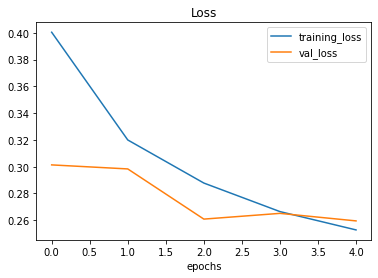

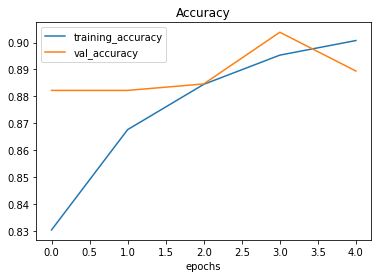

In [ ]:
# Plot loss curves
plot_loss_curves(inception_resnet_model.history)

In [ ]:
# Evaluate inception_resnet on whole test data
inception_resnet_loss, inception_resnet_acc = inception_resnet_model.evaluate(test_data)

run.finish()

87/87 [==============================] - 35s 399ms/step - loss: 0.2522 - accuracy: 0.9063


accuracy,▁▅▆▇█
epoch,▁▃▅▆█
loss,█▄▃▂▁
val_accuracy,▁▁▂█▃
val_loss,█▇▁▂▁
accuracy,0.90076
best_epoch,4
best_val_loss,0.2595
epoch,4
loss,0.25277
val_accuracy,0.88942


## Second experiment: Whole training data

There is where that confusing 40-20%, 80-20% training data part come into play.

All I did in the first experiment to cut the 80% of training data to half of its length, leaving the test data unchanged because that is the whole purpose of these experiments to try different variations of training data but evaluate to the model results on same test data.

The second experiment has the following data size:
* Total images - 13,808 (3,616 covid/10,192 normal)
  * Traning images - 11,045 (2,892 covid/8,153 normal)
  * Test images - 2,763 (724 covid/2,039 normal)

That being said, we'll have to bring the data (80-20%) in and unzip it.
All the steps are same, the only differnce is this time we have larger dataset.

So, this time we'll go through all these steps quicker.

In [ ]:
# Unzip data file from google drive  (uncomment if using colab)
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/covid_ready_dataset/covid_radiography_all_data.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
# Walk through the data directory and list number of files
for dirpath, dirnames, filenames in os.walk("covid_radiography_all_data"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 2 directories and 0 images in 'covid_radiography_all_data'.
there are 2 directories and 0 images in 'covid_radiography_all_data/test'.
there are 0 directories and 2039 images in 'covid_radiography_all_data/test/normal'.
there are 0 directories and 724 images in 'covid_radiography_all_data/test/covid'.
there are 2 directories and 0 images in 'covid_radiography_all_data/train'.
there are 0 directories and 8153 images in 'covid_radiography_all_data/train/normal'.
there are 0 directories and 2892 images in 'covid_radiography_all_data/train/covid'.


In [ ]:
# Set up train directory path
train_dir = 'covid_radiography_all_data/train'

# Create data generator and rescale images
train_datagen = ImageDataGenerator(rescale=1/255.)

# Load in data
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMG_SIZE,
                                               class_mode='binary',
                                               color_mode='rgb',
                                               seed=42)

Found 11045 images belonging to 2 classes.


Notice we don't instantiate the test data generator again, because it is the same test data that we'll have to use through out all of our experiments.

#### MobileNetV3 (All data)

In [ ]:
# Initialize wandb
run = wandb.init(project='MobileNetV3 vs. ResNetV2 vs. InceptionV3 vs. Inception_ResNetV2',
                 config={
                     "learning_rate": 0.001,
                     "epochs": 5,
                     "batch_size": 32,
                     "loss_function": "binary_crossentropy",
                     "architecture": "MobileNetV3",
                     "dataset": "Covid-19 CXR Full Data"
                 })

# Configure
config = wandb.config

# Initialize mobilenet model
tf.keras.backend.clear_session()
mobilenet_model_2 = create_model(mobilenet_url)
mobilenet_model_2.summary()

# Compile the model
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
mobilenet_model_2.compile(optimizer, config.loss_function, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1024)              1529968   
_________________________________________________________________
output_layer (Dense)         (None, 1)                 1025      
Total params: 1,530,993
Trainable params: 1,025
Non-trainable params: 1,529,968
_________________________________________________________________


In [ ]:
# Fit the model
mobilenet_history_2 = mobilenet_model_2.fit(train_data,
                                          epochs=config.epochs,
                                          batch_size=config.batch_size,
                                          steps_per_epoch=len(train_data),
                                          validation_data=test_data,
                                          validation_steps=int(0.15*len(test_data)),
                                          callbacks=[WandbCallback()])

Epoch 1/5
346/346 [==============================] - 45s 116ms/step - loss: 0.2965 - accuracy: 0.8795 - val_loss: 0.2237 - val_accuracy: 0.9207
Epoch 2/5
346/346 [==============================] - 39s 114ms/step - loss: 0.1858 - accuracy: 0.9354 - val_loss: 0.1802 - val_accuracy: 0.9423
Epoch 3/5
346/346 [==============================] - 39s 114ms/step - loss: 0.1567 - accuracy: 0.9450 - val_loss: 0.1501 - val_accuracy: 0.9567
Epoch 4/5
346/346 [==============================] - 39s 113ms/step - loss: 0.1400 - accuracy: 0.9519 - val_loss: 0.1809 - val_accuracy: 0.9255
Epoch 5/5
346/346 [==============================] - 39s 112ms/step - loss: 0.1289 - accuracy: 0.9545 - val_loss: 0.1216 - val_accuracy: 0.9567


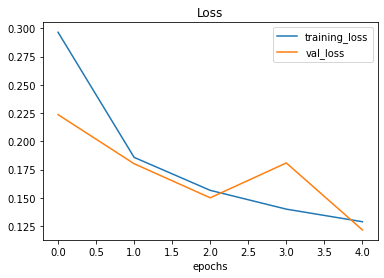

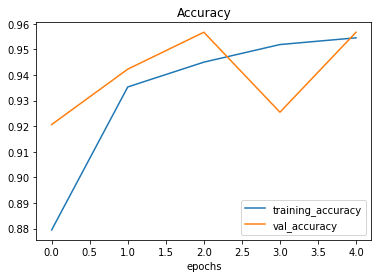

In [ ]:
# Plot the loss curve
plot_loss_curves(mobilenet_history_2)

In [ ]:
# Evaluate model
mobilenet_loss_2, mobilenet_acc_2 = mobilenet_model_2.evaluate(test_data)

run.finish()

87/87 [==============================] - 9s 105ms/step - loss: 0.1316 - accuracy: 0.9526


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▅█▂█
val_loss,█▅▃▅▁
accuracy,0.95455
best_epoch,4
best_val_loss,0.12165
epoch,4
loss,0.1289
val_accuracy,0.95673


#### Resnet50V2 (All data)

In [ ]:
# Initialize wandb
run = wandb.init(project='MobileNetV3 vs. ResNetV2 vs. InceptionV3 vs. Inception_ResNetV2',
                 config={
                     "learning_rate": 0.001,
                     "epochs": 5,
                     "batch_size": 32,
                     "loss_function": "binary_crossentropy",
                     "architecture": "ResNetV2",
                     "dataset": "Covid-19 CXR Full Data"
                 })

# Configure
config = wandb.config

# Initialize resnet model
tf.keras.backend.clear_session()
resnet_model_2 = create_model(resnet_url)
resnet_model_2.summary()

# Compile the model
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
resnet_model_2.compile(optimizer, config.loss_function, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Fit the model
resnet_history_2 = resnet_model_2.fit(train_data,
                                    epochs=config.epochs,
                                    batch_size=config.batch_size,
                                    steps_per_epoch=len(train_data),
                                    validation_data=test_data,
                                    validation_steps=int(0.15*len(test_data)),
                                    callbacks=[WandbCallback()])

Epoch 1/5
346/346 [==============================] - 73s 200ms/step - loss: 0.2956 - accuracy: 0.8828 - val_loss: 0.2331 - val_accuracy: 0.9038
Epoch 2/5
346/346 [==============================] - 67s 195ms/step - loss: 0.1985 - accuracy: 0.9261 - val_loss: 0.1563 - val_accuracy: 0.9447
Epoch 3/5
346/346 [==============================] - 68s 195ms/step - loss: 0.1699 - accuracy: 0.9367 - val_loss: 0.2113 - val_accuracy: 0.8990
Epoch 4/5
346/346 [==============================] - 67s 195ms/step - loss: 0.1528 - accuracy: 0.9446 - val_loss: 0.1417 - val_accuracy: 0.9327
Epoch 5/5
346/346 [==============================] - 68s 195ms/step - loss: 0.1426 - accuracy: 0.9488 - val_loss: 0.1208 - val_accuracy: 0.9543


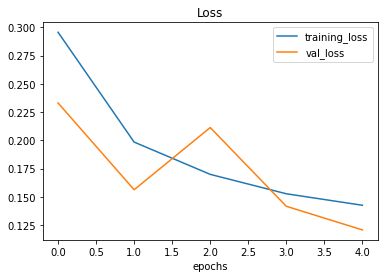

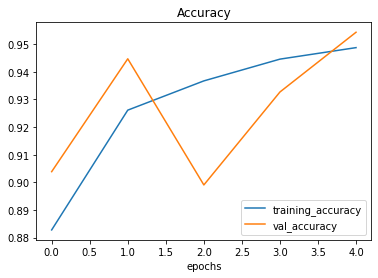

In [ ]:
# Plot the loss curves
plot_loss_curves(resnet_history_2)

In [ ]:
# Evaluate model
resnet_loss_2, resnet_acc_2 = resnet_model_2.evaluate(test_data)

run.finish()

87/87 [==============================] - 16s 186ms/step - loss: 0.1536 - accuracy: 0.9406


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▄▂▁▁
val_accuracy,▂▇▁▅█
val_loss,█▃▇▂▁
accuracy,0.94876
best_epoch,4
best_val_loss,0.12083
epoch,4
loss,0.14262
val_accuracy,0.95433


#### InceptionV3 (All data)

In [ ]:
# Initialize wandb
run = wandb.init(project='MobileNetV3 vs. ResNetV2 vs. InceptionV3 vs. Inception_ResNetV2',
                 config={
                     "learning_rate": 0.001,
                     "epochs": 5,
                     "batch_size": 32,
                     "loss_function": "binary_crossentropy",
                     "architecture": "InceptionV3",
                     "dataset": "Covid-19 CXR Full Data"
                 })

# Configure
config = wandb.config

# Initialize inception model
tf.keras.backend.clear_session()
inception_model_2 = create_model(inception_url)
inception_model_2.summary()

# Compile the model
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
inception_model_2.compile(optimizer, config.loss_function, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              21802784  
_________________________________________________________________
output_layer (Dense)         (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
# Fit the model
inception_history_2 = inception_model_2.fit(train_data,
                                            epochs=config.epochs,
                                            batch_size=config.batch_size,
                                            steps_per_epoch=len(train_data),
                                            validation_data=test_data,
                                            validation_steps=int(0.15*len(test_data)),
                                            callbacks=[WandbCallback()])

Epoch 1/5
346/346 [==============================] - 67s 175ms/step - loss: 0.3404 - accuracy: 0.8575 - val_loss: 0.2983 - val_accuracy: 0.8726
Epoch 2/5
346/346 [==============================] - 59s 170ms/step - loss: 0.2691 - accuracy: 0.8890 - val_loss: 0.2609 - val_accuracy: 0.8990
Epoch 3/5
346/346 [==============================] - 59s 169ms/step - loss: 0.2400 - accuracy: 0.9026 - val_loss: 0.2178 - val_accuracy: 0.9207
Epoch 4/5
346/346 [==============================] - 59s 169ms/step - loss: 0.2274 - accuracy: 0.9086 - val_loss: 0.2129 - val_accuracy: 0.9159
Epoch 5/5
346/346 [==============================] - 59s 170ms/step - loss: 0.2175 - accuracy: 0.9151 - val_loss: 0.2351 - val_accuracy: 0.9014


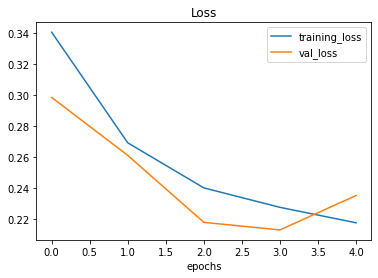

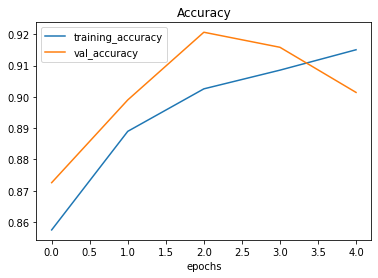

In [ ]:
# Plot the loss curves
plot_loss_curves(inception_history_2)

In [ ]:
# Evaluate model
inception_loss_2, inception_acc_2 = inception_model_2.evaluate(test_data)

run.finish()

87/87 [==============================] - 14s 162ms/step - loss: 0.2156 - accuracy: 0.9200


accuracy,▁▅▆▇█
epoch,▁▃▅▆█
loss,█▄▂▂▁
val_accuracy,▁▅█▇▅
val_loss,█▅▁▁▃
accuracy,0.91507
best_epoch,3
best_val_loss,0.21287
epoch,4
loss,0.21747
val_accuracy,0.90144


#### Inception_ResNetV2 (All data)

In [ ]:
# Initialize wandb
run = wandb.init(project='MobileNetV3 vs. ResNetV2 vs. InceptionV3 vs. Inception_ResNetV2',
                 config={
                     "learning_rate": 0.001,
                     "epochs": 5,
                     "batch_size": 32,
                     "loss_function": "binary_crossentropy",
                     "architecture": "Inception_ResNetV2",
                     "dataset": "Covid-19 CXR Full Data"
                 })

# Configure
config = wandb.config

# Initialize inception_resnet model
tf.keras.backend.clear_session()
inception_resnet_model_2 = create_model(inception_resnet_url)
inception_resnet_model_2.summary()

# Compile the model
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
inception_resnet_model_2.compile(optimizer, config.loss_function, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1536)              54336736  
_________________________________________________________________
output_layer (Dense)         (None, 1)                 1537      
Total params: 54,338,273
Trainable params: 1,537
Non-trainable params: 54,336,736
_________________________________________________________________


In [ ]:
# Fit the model
inception_resnet_history_2 = inception_resnet_model_2.fit(train_data,
                                                          epochs=config.epochs,
                                                          batch_size=config.batch_size,
                                                          steps_per_epoch=len(train_data),
                                                          validation_data=test_data,
                                                          validation_steps=int(0.15*len(test_data)),
                                                          callbacks=[WandbCallback()])

Epoch 1/5
346/346 [==============================] - 159s 416ms/step - loss: 0.3486 - accuracy: 0.8607 - val_loss: 0.2866 - val_accuracy: 0.8918
Epoch 2/5
346/346 [==============================] - 142s 408ms/step - loss: 0.2754 - accuracy: 0.8933 - val_loss: 0.2507 - val_accuracy: 0.8990
Epoch 3/5
346/346 [==============================] - 141s 408ms/step - loss: 0.2485 - accuracy: 0.9046 - val_loss: 0.2172 - val_accuracy: 0.9255
Epoch 4/5
346/346 [==============================] - 141s 408ms/step - loss: 0.2321 - accuracy: 0.9116 - val_loss: 0.2326 - val_accuracy: 0.9087
Epoch 5/5
346/346 [==============================] - 141s 408ms/step - loss: 0.2266 - accuracy: 0.9135 - val_loss: 0.1662 - val_accuracy: 0.9471


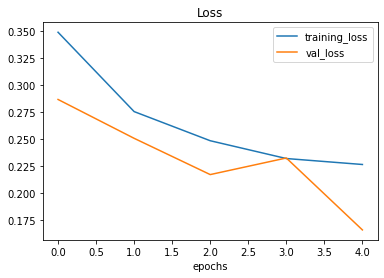

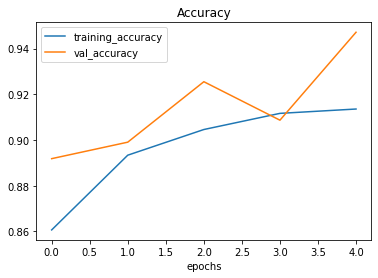

In [ ]:
# Plot the loss curves
plot_loss_curves(inception_resnet_history_2)

In [ ]:
# Evaluate model
inception_resnet_loss_2, inception_resnet_acc_2 = inception_resnet_model_2.evaluate(test_data)

run.finish()

87/87 [==============================] - 34s 391ms/step - loss: 0.2144 - accuracy: 0.9178


accuracy,▁▅▇██
epoch,▁▃▅▆█
loss,█▄▂▁▁
val_accuracy,▁▂▅▃█
val_loss,█▆▄▅▁
accuracy,0.91354
best_epoch,4
best_val_loss,0.16619
epoch,4
loss,0.22656
val_accuracy,0.94712


## Comparing results
Now we've got the results of all our models from two variation of experiments, let's compare them.

In [ ]:
# Create a list of lists of model results
model_results = [['mobilenet_50_percent', mobilenet_loss, mobilenet_acc],
                 ['mobilenet_all_data', mobilenet_loss_2, mobilenet_acc_2],
                 ['resnet_50_percent', resnet_loss, resnet_acc],
                 ['resnet_all_data', resnet_loss_2, resnet_acc_2],
                 ['inception_50_percent', inception_loss, inception_acc],
                 ['inception_all_data', inception_loss_2, inception_acc_2],
                 ['inception_resent_50_percent', inception_resnet_loss, inception_resnet_acc],
                 ['inception_resnet_all_data', inception_resnet_loss_2, inception_resnet_acc_2]]

all_results = pd.DataFrame(model_results, columns=['model', 'loss', 'accuracy'])
all_results

,model,loss,accuracy
0,mobilenet_50_percent,0.166158,0.944263
1,mobilenet_all_data,0.131570,0.952588
2,resnet_50_percent,0.179324,0.926529
3,resnet_all_data,0.153575,0.940644
4,inception_50_percent,0.248659,0.902642
5,inception_all_data,0.215642,0.920015
6,inception_resent_50_percent,0.252165,0.906261
7,inception_resnet_all_data,0.214406,0.917843


From our experiments, it looks like `MobileNetV3` performed the best. Although `ResNet50V2` has almost identical results as `MobileNetV3` but I'm considering MobileNetV3 to go ahead for fine-tuning, because it brings efficient results with smaller architecture as compared to ResNet50V2.

Notice models overfitting was not under consideration for these experiments. The purpose of these experiments solely to pick what model is most suitable for our data.

Overfitting will be handled in the next phase which is fine-tuning with transfer learning, that will be challenging epecially when we have highly imblance data (more normal images than covid).

Let's see how it goes...